In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import arviz as az
import pymc as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import cellbayesassay as cba
import os.path
import re
import warnings
import attila_utils

## Data import

In [2]:
TI_conc_fpaths = {
    (2, 4, 5, 6, 7, 8): 'a',
    (3, 9): 'b',
}

In [3]:
fpath = '../../resources/cell-based-assays/data-format-specification.xlsx'
qps_exp_num = pd.read_excel(fpath, sheet_name='Allowed values', usecols=['Experiment', 'QPS experiment number'], index_col='Experiment')
qps_exp_num = qps_exp_num.dropna()
s = pd.concat([pd.Series(v, index=list(k)) for k, v in TI_conc_fpaths.items()])
qps_exp_num['exp_type'] = qps_exp_num['QPS experiment number'].apply(lambda x: s.loc[x])
qps_exp_num['fpath'] = qps_exp_num.exp_type.apply(lambda x: '../../resources/cell-based-assays/test-items3' + x + '.csv')
qps_exp_num

,QPS experiment number,exp_type,fpath
Experiment,,,
Aβ clearance (BV2 cells),3.0,b,../../resources/cell-based-assays/test-items3b...
Aβ release (H4 cells),4.0,a,../../resources/cell-based-assays/test-items3a...
Aβ toxicity (primary neurons),2.0,a,../../resources/cell-based-assays/test-items3a...
LPS neuroinflammation (BV2 cells),6.0,a,../../resources/cell-based-assays/test-items3a...
Neurite outgrowth (primary neurons),7.0,a,../../resources/cell-based-assays/test-items3a...
Tau phoshorylation,5.0,a,../../resources/cell-based-assays/test-items3a...
Trophic factor withdrawal (primary neurons),8.0,a,../../resources/cell-based-assays/test-items3a...
Tau aggregation,9.0,b,../../resources/cell-based-assays/test-items3b...


In [4]:
data_fpath = '../../resources/cell-based-assays/data-format-specification_NIA_AB-CO25360-cleaned.xlsx'
data_a, data_b = [cba.get_data(data_fpath, sheet_name='Sheet1', TI_fpath='../../resources/cell-based-assays/test-items3' + et + '.csv') for et in ['a', 'b']]
data = pd.concat([df.loc[df.Experiment.isin(qps_exp_num.loc[qps_exp_num.exp_type == et].index)] for et, df in zip(['a', 'b'], [data_a, data_b])], axis=0)
data

,Study,Experiment,Assay,Batch,Plate,TI,Name,conc,concentration,conc_log10,Activity
0,CO25360,Aβ release (H4 cells),Aβ38,1,1,TI1,Valproic acid,c1,5.000000e-05,-4.30103,3431.0
1,CO25360,Aβ release (H4 cells),Aβ38,1,1,TI1,Valproic acid,c1,5.000000e-05,-4.30103,3704.0
2,CO25360,Aβ release (H4 cells),Aβ38,1,1,TI1,Valproic acid,c1,5.000000e-05,-4.30103,3536.0
3,CO25360,Aβ release (H4 cells),Aβ38,1,1,TI1,Valproic acid,c1,5.000000e-05,-4.30103,3595.0
4,CO25360,Aβ release (H4 cells),Aβ38,1,1,TI1,Valproic acid,c1,5.000000e-05,-4.30103,3863.0
...,...,...,...,...,...,...,...,...,...,...,...
2749,CO25360,Aβ clearance (BV2 cells),Aβ42 SN,2,1,TI17,C188-9,c3,1.000000e-07,-7.00000,105.0
2750,CO25360,Aβ clearance (BV2 cells),Aβ42 SN,2,1,TI17,C188-9,c3,1.000000e-07,-7.00000,117.0
2751,CO25360,Aβ clearance (BV2 cells),Aβ42 SN,2,1,TI17,C188-9,c3,1.000000e-07,-7.00000,112.0
2752,CO25360,Aβ clearance (BV2 cells),Aβ42 SN,2,1,TI17,C188-9,c3,1.000000e-07,-7.00000,88.0


## Check data

In [5]:
check_data = True
if check_data:
    testdf = cba.fit_multiple_units(data, unit_list=None, do_fit=False, do_print=False)
    print(testdf)

                                                 study  \
CO25360 Aβ clearance (BV2 cells) Aβ42 Ly TI1   CO25360   
                                         TI10  CO25360   
                                         TI11  CO25360   
                                         TI12  CO25360   
                                         TI13  CO25360   
...                                                ...   
        Aβ release (H4 cells)    Aβ42    TI5   CO25360   
                                         TI6   CO25360   
                                         TI7   CO25360   
                                         TI8   CO25360   
                                         TI9   CO25360   

                                                                  exper  \
CO25360 Aβ clearance (BV2 cells) Aβ42 Ly TI1   Aβ clearance (BV2 cells)   
                                         TI10  Aβ clearance (BV2 cells)   
                                         TI11  Aβ clearance (BV2 cells)   
   

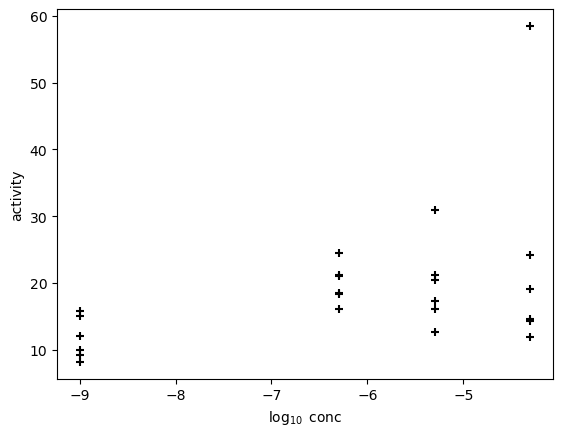

In [6]:
def data_plotter(exper='Aβ clearance (BV2 cells)', assay='Aβ42 Ly', TI='TI1', data=data):
    fig, ax = plt.subplots()
    data_reshaped = cba.extract_regr_data('CO25360', exper, assay, TI, data, return_data_reshaped=True, accept_multi_batches=True)
    ax = cba.plot_data(ax, data_reshaped)
    return((fig, ax))

fig, ax = data_plotter(exper='Aβ clearance (BV2 cells)', assay='Aβ42 Ly', TI='TI1')

## HCQ + TUDCA

/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


['named-figure/HCQ-TUDCA_Aβ-clearance-BV2-cells_Aβ42-Ly.png',
 'named-figure/HCQ-TUDCA_Aβ-clearance-BV2-cells_Aβ42-Ly.pdf']

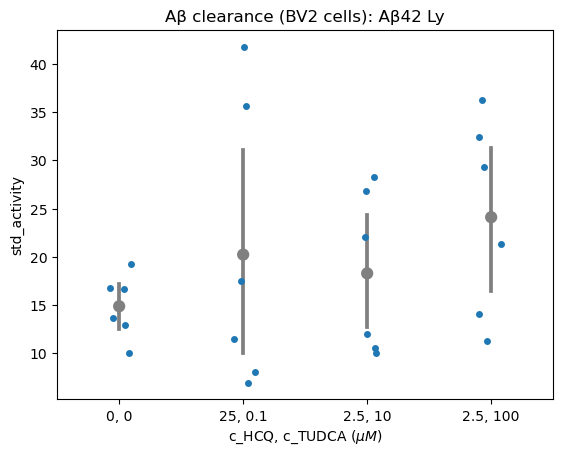

In [7]:

conc2conc_pair = {
    'c1': (25e-6, 0.1e-6),
    'c2': (2.5e-6, 100e-6),
    'c3': (2.5e-6, 10e-6),
}
conc2conc_pair_str = {
    'c1': '25, 0.1',
    'c2': '2.5, 100',
    'c3': '2.5, 10',
}
#conc2conc_pair_str = {
#    'c1': r'$25\mu M, 0.1\mu M$',
#    'c2': r'$2.5\mu M, 100\mu M$',
#    'c3': r'$2.5\mu M, 10\mu M$',
#}

def data_plotter_2drug_treatment(exper='Aβ clearance (BV2 cells)', assay='Aβ42 Ly', data=data, return_data_reshaped=False):
    TI = 'TI27'
    data_reshaped = data_reshaped = cba.extract_regr_data('CO25360', exper, assay, TI, data, return_data_reshaped=True, accept_multi_batches=True)
    df = pd.concat([data_reshaped.conc.apply(lambda c: conc2conc_pair[c][i] if c in conc2conc_pair.keys() else 1e-9) for i in range(2)], axis=1)
    df.columns = ['c_HCQ', 'c_TUDCA']
    data_reshaped['c_HCQ, c_TUDCA'] = data_reshaped.conc.apply(lambda c: conc2conc_pair_str[c] if c in conc2conc_pair_str.keys() else '0, 0')
    data_reshaped['c_HCQ, c_TUDCA'] = pd.Categorical(data_reshaped['c_HCQ, c_TUDCA'], categories=['0, 0', '25, 0.1', '2.5, 10', '2.5, 100'], ordered=True)
    data_reshaped = pd.concat([data_reshaped, df], axis=1)
    if return_data_reshaped:
        return(data_reshaped)
    fig, ax = plt.subplots()
    sns.pointplot(y='std_activity', x='c_HCQ, c_TUDCA', data=data_reshaped, ax=ax, color='gray', linestyles='none')
    sns.stripplot(y='std_activity', x='c_HCQ, c_TUDCA', data=data_reshaped, ax=ax)
    ax.set_xlabel(ax.get_xlabel() + r' ($\mu M$)')
    ax.set_title(exper + ': ' + assay)
    return((fig, ax))

exper = 'Aβ clearance (BV2 cells)'
assay = 'Aβ42 Ly'
fig, ax = data_plotter_2drug_treatment(exper=exper, assay=assay)
attila_utils.savefig(fig, 'HCQ-TUDCA_' + '_'.join([re.sub('\W+', '-', s).strip('-') for s in [exper, assay]]))

/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


['named-figure/HCQ-TUDCA_Aβ-clearance-BV2-cells_Aβ42-SN.png',
 'named-figure/HCQ-TUDCA_Aβ-clearance-BV2-cells_Aβ42-SN.pdf']

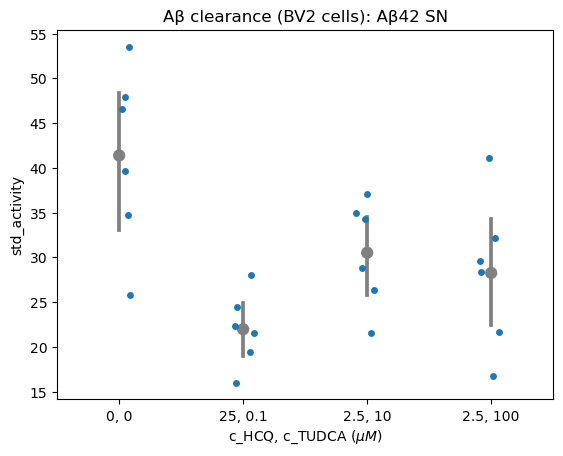

In [8]:
exper = 'Aβ clearance (BV2 cells)'
assay = 'Aβ42 SN'
fig, ax = data_plotter_2drug_treatment(exper=exper, assay=assay)
attila_utils.savefig(fig, 'HCQ-TUDCA_' + '_'.join([re.sub('\W+', '-', s).strip('-') for s in [exper, assay]]))

/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


['named-figure/HCQ-TUDCA_Aβ-release-H4-cells_Aβ38.png',
 'named-figure/HCQ-TUDCA_Aβ-release-H4-cells_Aβ38.pdf']

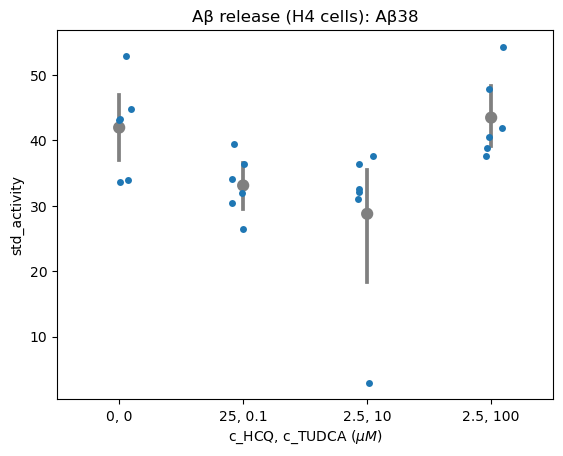

In [9]:
exper = 'Aβ release (H4 cells)'
assay = 'Aβ38'
fig, ax = data_plotter_2drug_treatment(exper=exper, assay=assay)
attila_utils.savefig(fig, 'HCQ-TUDCA_' + '_'.join([re.sub('\W+', '-', s).strip('-') for s in [exper, assay]]))

/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


['named-figure/HCQ-TUDCA_Aβ-release-H4-cells_Aβ40.png',
 'named-figure/HCQ-TUDCA_Aβ-release-H4-cells_Aβ40.pdf']

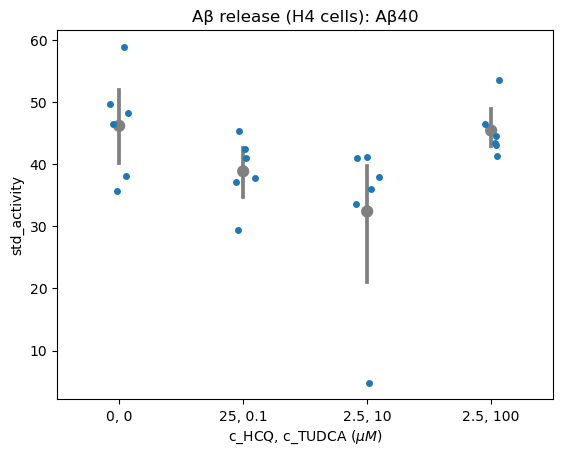

In [10]:
exper = 'Aβ release (H4 cells)'
assay = 'Aβ40'
fig, ax = data_plotter_2drug_treatment(exper=exper, assay=assay)
attila_utils.savefig(fig, 'HCQ-TUDCA_' + '_'.join([re.sub('\W+', '-', s).strip('-') for s in [exper, assay]]))

/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


['named-figure/HCQ-TUDCA_Aβ-release-H4-cells_Aβ42.png',
 'named-figure/HCQ-TUDCA_Aβ-release-H4-cells_Aβ42.pdf']

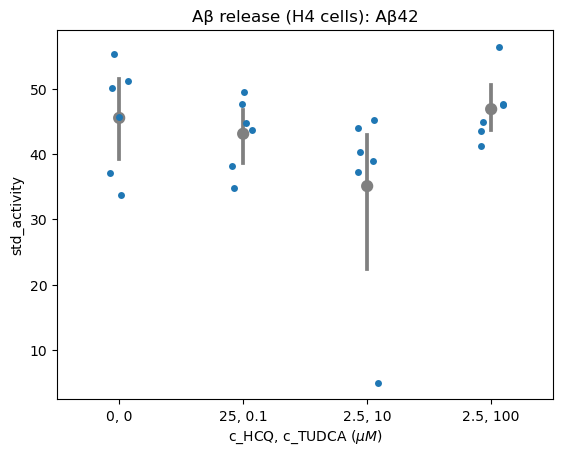

In [11]:
exper = 'Aβ release (H4 cells)'
assay = 'Aβ42'
fig, ax = data_plotter_2drug_treatment(exper=exper, assay=assay)
attila_utils.savefig(fig, 'HCQ-TUDCA_' + '_'.join([re.sub('\W+', '-', s).strip('-') for s in [exper, assay]]))

## Fitting model

In [12]:
maindir = '../../results/2024-04-29-cell-bayes/'

if not os.path.exists(maindir + 'idatas/fpaths.csv'):
    idatadf = cba.fit_multiple_units(data, unit_list=None, accept_multi_batches=True)
    idatas = idatadf.idata
    fpathdf = cba.idatas_to_netcdf(idatas.dropna(), subdir='idatas/', maindir=maindir)
    print('idatas written to netcdf')
    ## write 3 records for which fit resulted in None instead of arviz.data.inference_data.InferenceData
    #fpath = '../../results/2024-04-21-cell-bayes/fits-resulting-in-None.csv'
    #idatas.loc[idatas.apply(lambda x: not isinstance(x, az.data.inference_data.InferenceData))].to_csv(fpath)
else:
    idatas = cba.idatas_from_netcdf(subdir='idatas/', maindir=maindir)
    print('idatas read from netcdf')

idatas = cba.sort_index_TI(idatas)
idatas = idatas.loc[idatas.index.to_frame().TI != 'TI27']
idatas

idatas read from netcdf


study    experiment                assay    TI  
CO25360  Aβ clearance (BV2 cells)  Aβ42 Ly  TI1     (posterior, log_likelihood, sample_stats, obse...
                                            TI2     (posterior, log_likelihood, sample_stats, obse...
                                            TI3     (posterior, log_likelihood, sample_stats, obse...
                                            TI4     (posterior, log_likelihood, sample_stats, obse...
                                            TI5     (posterior, log_likelihood, sample_stats, obse...
                                                                          ...                        
         Aβ release (H4 cells)     Aβ42     TI22    (posterior, log_likelihood, sample_stats, obse...
                                            TI23    (posterior, log_likelihood, sample_stats, obse...
                                            TI24    (posterior, log_likelihood, sample_stats, obse...
                                 

## Fitted curves: posterior sample

In [13]:
plot_sampled_curves = False
fpath_suffix = '' if plot_sampled_curves else '-no-curves'

def assay_plotter(experiment, assay, plot_sampled_curves=plot_sampled_curves, compound_name_title=True):
    unit_list = idatas.loc(axis=0)[:, experiment, assay, :].index.to_numpy()
    fig, ax = cba.plot_multiple_units(unit_list, data, idatas, plot_sampled_curves=plot_sampled_curves, compound_name_title=compound_name_title)
    fig.suptitle(experiment + '\n' + assay)
    return((fig, ax))

for e, a in data[['Experiment', 'Assay']].apply(lambda x: (x.iloc[0], x.iloc[1]), axis=1).unique():
    print(e, a)

Aβ release (H4 cells) Aβ38
Aβ release (H4 cells) Aβ40
Aβ release (H4 cells) Aβ42
Aβ clearance (BV2 cells) Aβ42 Ly
Aβ clearance (BV2 cells) Aβ42 SN


['named-figure/fitted-curves-Aβ-clearance-BV2-cells-Aβ42-Ly-no-curves.png',
 'named-figure/fitted-curves-Aβ-clearance-BV2-cells-Aβ42-Ly-no-curves.pdf']

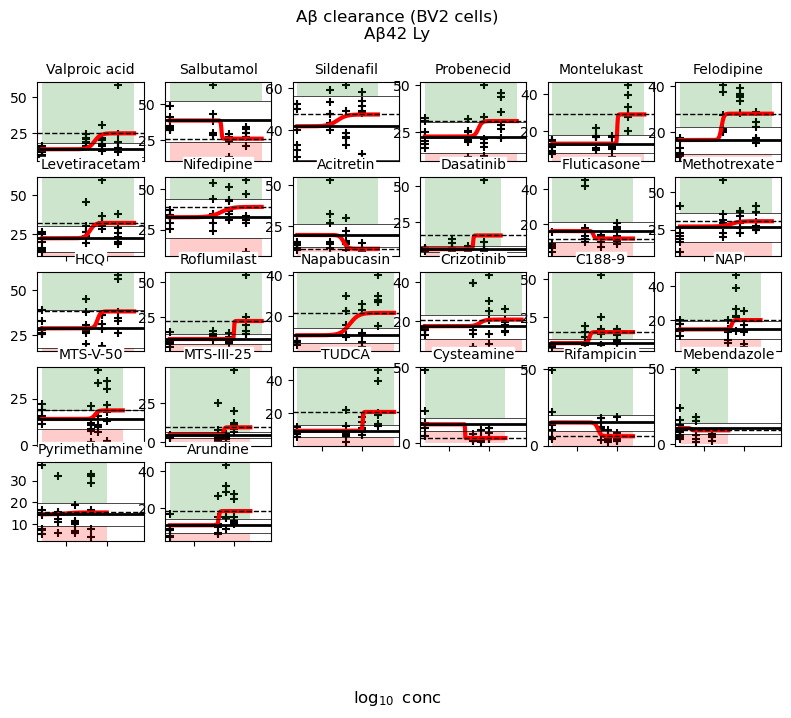

In [14]:
experiment = 'Aβ clearance (BV2 cells)'
assay = 'Aβ42 Ly'
fig, ax = assay_plotter(experiment, assay)
attila_utils.savefig(fig, 'fitted-curves-' + re.sub('[ ()]+', '-', experiment + ' ' + assay) + ('' if plot_sampled_curves else '-no-curves'))

/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:267: RuntimeWarning: overflow encountered in exp
  y_sigmoid_1_mean = y_1_mean + (y_0_mean - y_1_mean) / (1 + np.exp(k_mean * (xx - EC_50_mean)))


['named-figure/fitted-curves-Aβ-clearance-BV2-cells-Aβ42-SN-no-curves.png',
 'named-figure/fitted-curves-Aβ-clearance-BV2-cells-Aβ42-SN-no-curves.pdf']

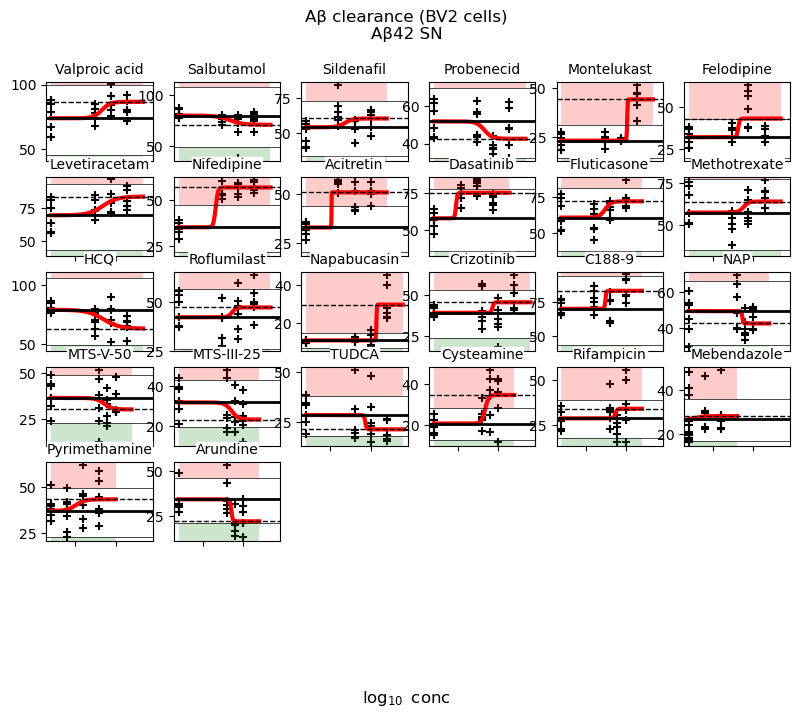

In [15]:
experiment = 'Aβ clearance (BV2 cells)'
assay = 'Aβ42 SN'
fig, ax = assay_plotter(experiment, assay)
attila_utils.savefig(fig, 'fitted-curves-' + re.sub('[ ()]+', '-', experiment + ' ' + assay) + ('' if plot_sampled_curves else '-no-curves'))

['named-figure/fitted-curves-Aβ-release-H4-cells-Aβ38-no-curves.png',
 'named-figure/fitted-curves-Aβ-release-H4-cells-Aβ38-no-curves.pdf']

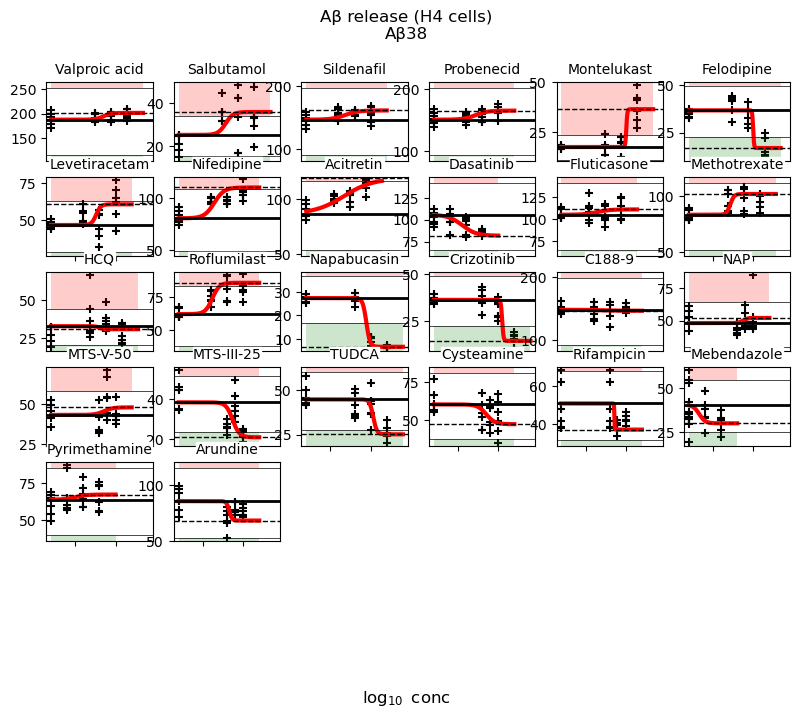

In [16]:
experiment = 'Aβ release (H4 cells)'
assay = 'Aβ38'
fig, ax = assay_plotter(experiment, assay)
attila_utils.savefig(fig, 'fitted-curves-' + re.sub('[ ()]+', '-', experiment + ' ' + assay) + ('' if plot_sampled_curves else '-no-curves'))

['named-figure/fitted-curves-Aβ-release-H4-cells-Aβ40-no-curves.png',
 'named-figure/fitted-curves-Aβ-release-H4-cells-Aβ40-no-curves.pdf']

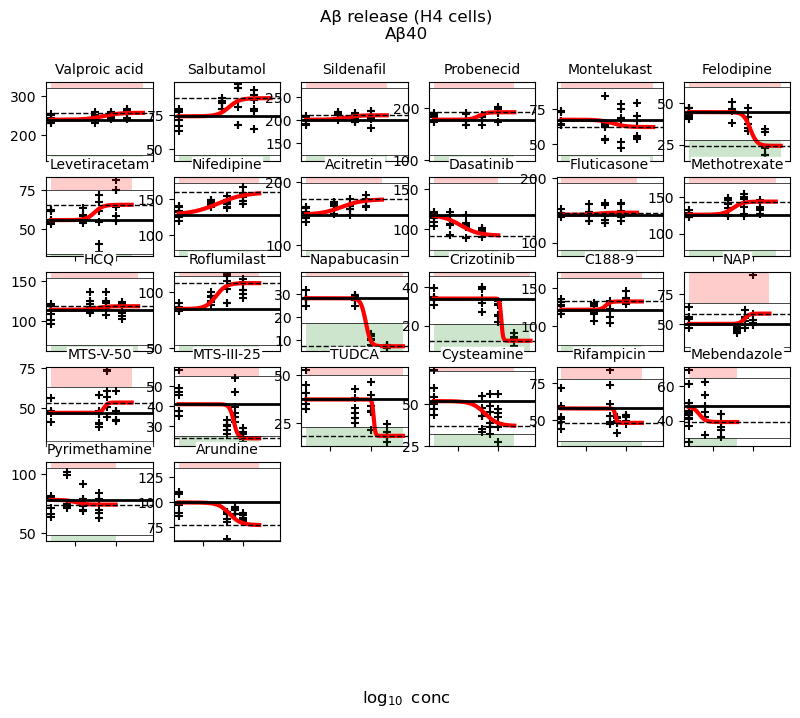

In [17]:
experiment = 'Aβ release (H4 cells)'
assay = 'Aβ40'
fig, ax = assay_plotter(experiment, assay)
attila_utils.savefig(fig, 'fitted-curves-' + re.sub('[ ()]+', '-', experiment + ' ' + assay) + ('' if plot_sampled_curves else '-no-curves'))

['named-figure/fitted-curves-Aβ-release-H4-cells-Aβ42-no-curves.png',
 'named-figure/fitted-curves-Aβ-release-H4-cells-Aβ42-no-curves.pdf']

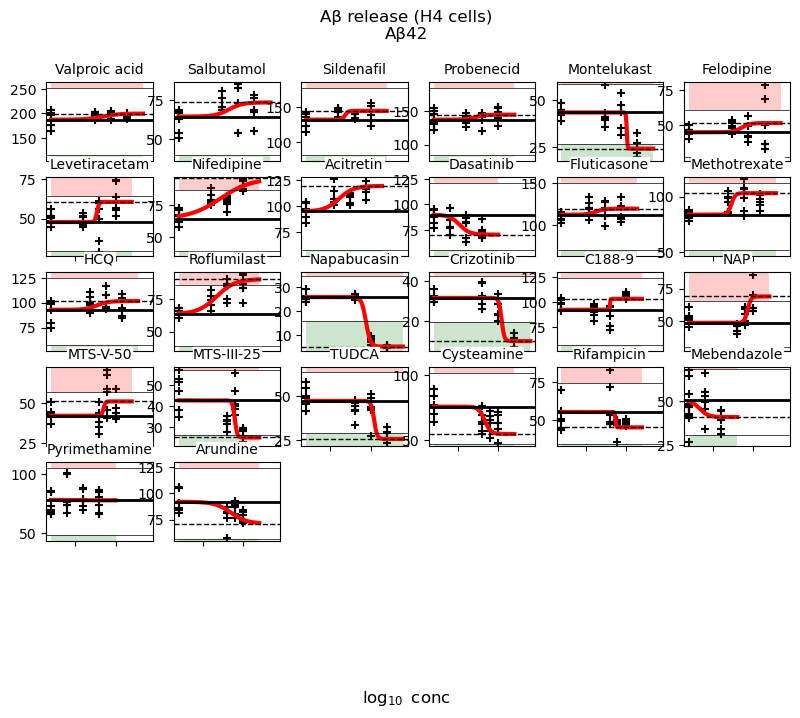

In [18]:
experiment = 'Aβ release (H4 cells)'
assay = 'Aβ42'
fig, ax = assay_plotter(experiment, assay)
attila_utils.savefig(fig, 'fitted-curves-' + re.sub('[ ()]+', '-', experiment + ' ' + assay) + ('' if plot_sampled_curves else '-no-curves'))

## MCMC diagnostics

In [19]:
cba.get_diagnostics_series(idatas, az.ess)

In [20]:
cba.get_diagnostics_series(idatas, az.rhat, vmax=1.1)

In [21]:
cba.get_diagnostics_series(idatas, az.mcse, vmax=10)

In [22]:
df = cba.get_diagnostics_series(idatas, az.mcse, return_df=True).drop('k', level='parameter', axis=0)
df.style.format(precision=3).background_gradient(axis=None, vmin=df.min().min(), vmax=df.max().max(), cmap='hot')

['named-figure/ess.png', 'named-figure/ess.pdf']

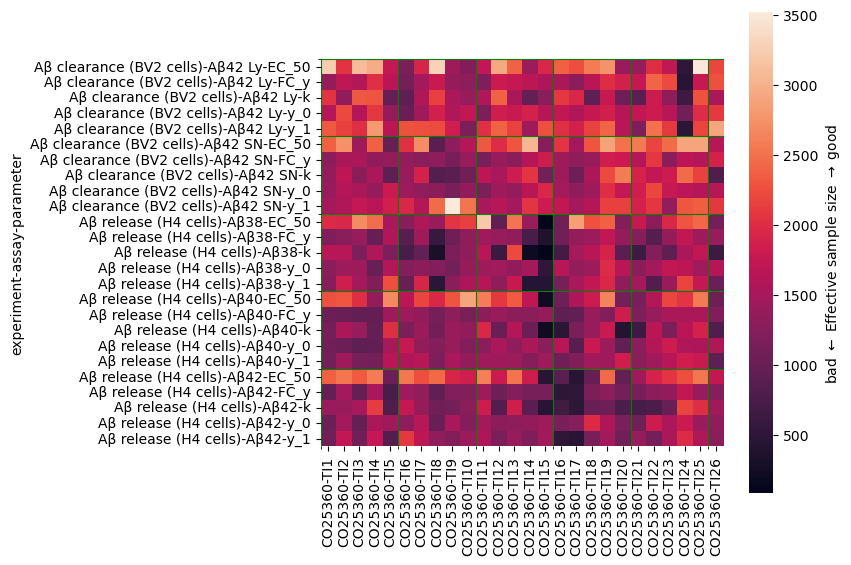

In [23]:
g = cba.diagnostics_series_heatmap(idatas, az.ess, yticklabels=True)
attila_utils.savefig(g.figure, 'ess')

['named-figure/rhat.png', 'named-figure/rhat.pdf']

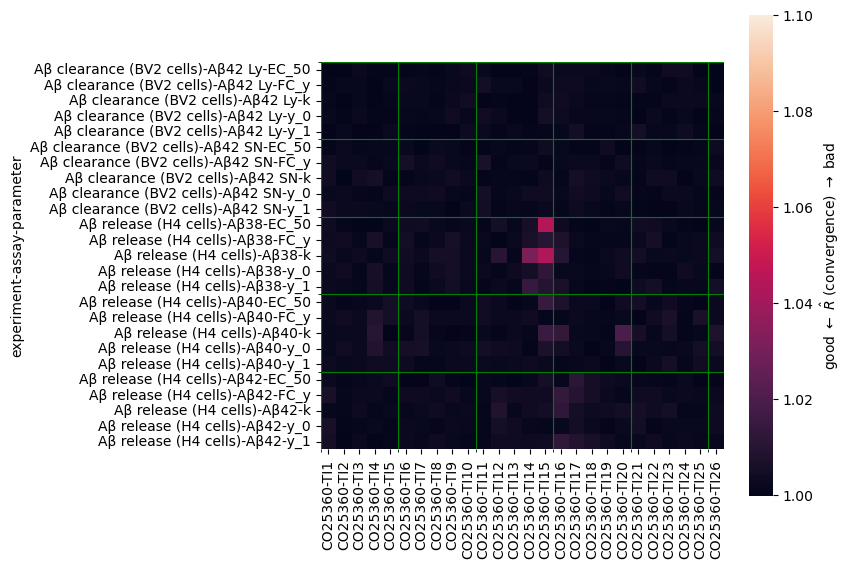

In [24]:
g = cba.diagnostics_series_heatmap(idatas, az.rhat, yticklabels=True, vmax=1.1)
attila_utils.savefig(g.figure, 'rhat')

['named-figure/mcse.png', 'named-figure/mcse.pdf']

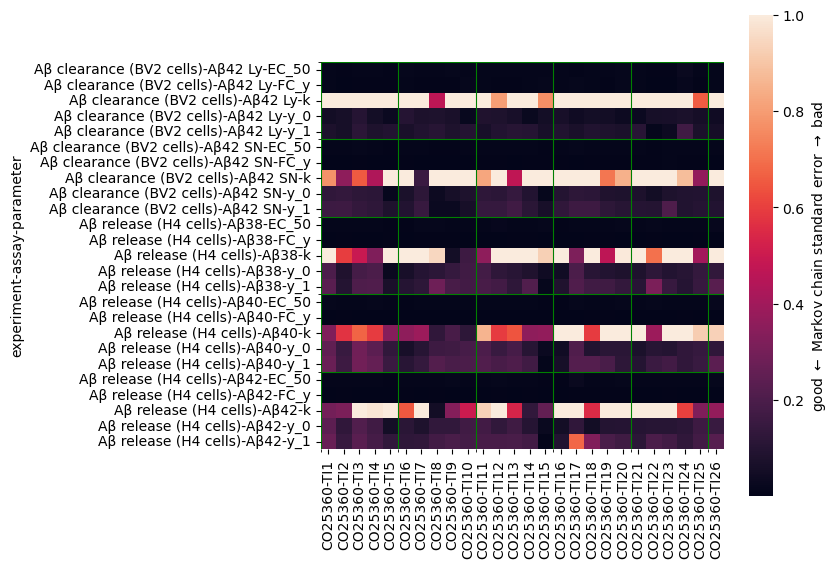

In [25]:
g = cba.diagnostics_series_heatmap(idatas, az.mcse, yticklabels=True, vmax=1)
attila_utils.savefig(g.figure, 'mcse')

## Posteriors and Bayes factors

In [29]:
poor_fits = []
fpath = '../../results/2024-04-29-cell-bayes/H102_posteriors.csv'
if not os.path.exists(fpath):
    H102_posteriors = cba.get_H102_posterior_from_idatas(idatas, poor_fits)
    H102_posteriors = cba.sort_index_TI(H102_posteriors)
    df = cba.get_TI_name('/Users/jonesa7/CTNS/resources/cell-based-assays/test-items3a.csv')
    H102_posteriors['name'] = df.loc[H102_posteriors.index.to_frame().apply(lambda r: (r.loc['study'], r.loc['TI']), axis=1), 'Name'].to_list()
    H102_posteriors.to_csv(fpath)
else:
    H102_posteriors = pd.read_csv(fpath, index_col=[0, 1, 2, 3])
    
H102_posteriors

H1       H0       H2  \
study   experiment               assay   TI                                
CO25360 Aβ clearance (BV2 cells) Aβ42 Ly TI1   0.92525  0.07425  0.00050   
                                         TI2   0.00000  0.78775  0.21225   
                                         TI3   0.15525  0.84225  0.00250   
                                         TI4   0.53250  0.46625  0.00125   
                                         TI5   0.99800  0.00200  0.00000   
...                                                ...      ...      ...   
        Aβ release (H4 cells)    Aβ42    TI22  0.19000  0.81000  0.00000   
                                         TI23  0.08125  0.91425  0.00450   
                                         TI24  0.09825  0.89575  0.00600   
                                         TI25  0.00625  0.96450  0.02925   
                                         TI26  0.08800  0.91050  0.00150   

                                                        name  
study   experiment               assay   TI                   
CO25360 Aβ clearance (BV2 cells) Aβ42 Ly TI1   Valproic acid  
                                         TI2      Salbutamol  
                                         TI3      Sildenafil  
                                         TI4      Probenecid  
                                         TI5     Montelukast  
...                                                      ...  
        Aβ release (H4 cells)    Aβ42    TI22     Cysteamine  
                                         TI23     Rifampicin  
                                         TI24    Mebendazole  
                                         TI25  Pyrimethamine  
                                         TI26       Arundine  

[130 rows x 4 columns]

In [30]:
BF10 = cba.BF10_from_H102_posteriors_long(cba.pseudocount_to_H102_posteriors(H102_posteriors))
fpath = '../../results/2024-04-29-cell-bayes/BF10.csv'
BF10.to_csv(fpath)
BF10

Study  \
study   experiment               assay   TI              
CO25360 Aβ clearance (BV2 cells) Aβ42 Ly TI1   CO25360   
                                         TI2   CO25360   
                                         TI3   CO25360   
                                         TI4   CO25360   
                                         TI5   CO25360   
...                                                ...   
        Aβ release (H4 cells)    Aβ42    TI22  CO25360   
                                         TI23  CO25360   
                                         TI24  CO25360   
                                         TI25  CO25360   
                                         TI26  CO25360   

                                                             Experiment  \
study   experiment               assay   TI                               
CO25360 Aβ clearance (BV2 cells) Aβ42 Ly TI1   Aβ clearance (BV2 cells)   
                                         TI2   Aβ clearance (BV2 cells)   
                                         TI3   Aβ clearance (BV2 cells)   
                                         TI4   Aβ clearance (BV2 cells)   
                                         TI5   Aβ clearance (BV2 cells)   
...                                                                 ...   
        Aβ release (H4 cells)    Aβ42    TI22     Aβ release (H4 cells)   
                                         TI23     Aβ release (H4 cells)   
                                         TI24     Aβ release (H4 cells)   
                                         TI25     Aβ release (H4 cells)   
                                         TI26     Aβ release (H4 cells)   

                                                 Assay    TI          BF  \
study   experiment               assay   TI                                
CO25360 Aβ clearance (BV2 cells) Aβ42 Ly TI1   Aβ42 Ly   TI1   12.461279   
                                         TI2   Aβ42 Ly   TI2    0.000159   
                                         TI3   Aβ42 Ly   TI3    0.184328   
                                         TI4   Aβ42 Ly   TI4    1.142091   
                                         TI5   Aβ42 Ly   TI5  499.000000   
...                                                ...   ...         ...   
        Aβ release (H4 cells)    Aβ42    TI22     Aβ42  TI22    0.234568   
                                         TI23     Aβ42  TI23    0.088871   
                                         TI24     Aβ42  TI24    0.109685   
                                         TI25     Aβ42  TI25    0.006480   
                                         TI26     Aβ42  TI26    0.096650   

                                                2 log BF  
study   experiment               assay   TI               
CO25360 Aβ clearance (BV2 cells) Aβ42 Ly TI1    5.045252  
                                         TI2  -17.497245  
                                         TI3   -3.382080  
                                         TI4    0.265722  
                                         TI5   12.425212  
...                                                  ...  
        Aβ release (H4 cells)    Aβ42    TI22  -2.900020  
                                         TI23  -4.841146  
                                         TI24  -4.420292  
                                         TI25 -10.078057  
                                         TI26  -4.673314  

[130 rows x 6 columns]

In [31]:
%connect_info

{
  "shell_port": 53777,
  "iopub_port": 53778,
  "stdin_port": 53779,
  "control_port": 53781,
  "hb_port": 53780,
  "ip": "127.0.0.1",
  "key": "d1069d9c-2beb772b8792009d61022995",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": "python3",
  "jupyter_session": "/Users/jonesa7/CTNS/notebooks/2024-04-29-cell-bayes/2024-04-29-cell-bayes.ipynb"
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-de5bc1ec-85e5-47ea-879d-b044a37f99a8.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
